In [1]:
# 04_Model_Building_and_Evaluation.ipynb

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,mean_squared_error, mean_absolute_error, r2_score,confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load data and repeat feature engineering (same as in notebook 3)
stats = pd.read_csv('cleaned_stats.csv')
results = pd.read_csv('cleaned_results.csv')

# Recreate standings and df (same steps as before)
def compute_season_points(df):
    home = df.groupby(['season', 'home_team']).agg(
        home_wins=('result', lambda x: (x=='H').sum()),
        home_draws=('result', lambda x: (x=='D').sum()),
        home_goals_for=('home_goals', 'sum'),
        home_goals_against=('away_goals', 'sum')
    ).reset_index().rename(columns={'home_team': 'team'})
    away = df.groupby(['season', 'away_team']).agg(
        away_wins=('result', lambda x: (x=='A').sum()),
        away_draws=('result', lambda x: (x=='D').sum()),
        away_goals_for=('away_goals', 'sum'),
        away_goals_against=('home_goals', 'sum')
    ).reset_index().rename(columns={'away_team': 'team'})
    standings = home.merge(away, on=['season', 'team'], how='outer').fillna(0)
    standings['wins'] = standings['home_wins'] + standings['away_wins']
    standings['draws'] = standings['home_draws'] + standings['away_draws']
    standings['losses'] = 38 - standings['wins'] - standings['draws']
    standings['points'] = 3*standings['wins'] + standings['draws']
    standings['goals_for'] = standings['home_goals_for'] + standings['away_goals_for']
    standings['goals_against'] = standings['home_goals_against'] + standings['away_goals_against']
    standings['goal_diff'] = standings['goals_for'] - standings['goals_against']
    standings = standings.sort_values(['season', 'points', 'goal_diff', 'goals_for'],
                                       ascending=[True, False, False, False])
    standings['rank'] = standings.groupby('season').cumcount() + 1
    return standings

standings = compute_season_points(results)
stats['season'] = stats['season'].astype(str)
standings['season'] = standings['season'].astype(str)

df = stats.merge(standings[['season', 'team', 'rank', 'points', 'goals_for', 'goals_against',
                            'wins', 'draws', 'losses']],
                 on=['season', 'team'], how='left', suffixes=('', '_target'))
df['top4'] = (df['rank'] <= 4).astype(int)
df['relegated'] = (df['rank'] >= 18).astype(int)

# Sort and create lag features
df = df.sort_values(['team', 'season_start'])
feature_cols = [c for c in stats.columns if c not in
                ['team', 'season', 'season_start', 'wins', 'losses', 'draws',
                 'points', 'goal_diff', 'total_matches', 'strength', 'cluster']]
lagged = df.groupby('team')[feature_cols].shift(1).add_suffix('_lag1')
df = pd.concat([df, lagged], axis=1)
for col in feature_cols:
    df[col + '_ma2'] = df.groupby('team')[col].transform(lambda x: x.rolling(2, min_periods=1).mean().shift(1))
df = df.dropna(subset=df.filter(like='_lag1').columns, how='all').reset_index(drop=True)

# Split: train on <=2014, valid 2015, test >=2016
train = df[df['season_start'] <= 2014]
valid = df[df['season_start'] == 2015]
test = df[df['season_start'] >= 2016]

# Combine train and valid for final model training (after hyperparameter tuning)
train_val = pd.concat([train, valid])

# Function to get features and target
def get_X_y(df, target_col, classification=True):
    feat_pattern = ['_lag1$', '_ma2$']
    feat_cols = [c for c in df.columns if any(p in c for p in feat_pattern)]
    X = df[feat_cols].copy()
    le = LabelEncoder()
    X['team_encoded'] = le.fit_transform(df['team'])
    y = df[target_col].copy()
    if classification and y.dtype not in ['int64', 'int32']:
        y = y.astype(int)
    return X, y, feat_cols, le


C:\Users\phill\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 4.1 Hyperparameter Optimization (Example for one target) 

# We'll demonstrate tuning for 'goals_scored' regression using XGBoost
target_info = {'name': 'goals_scored', 'type': 'regression', 'col': 'goals'}

X_train, y_train, _, le_train = get_X_y(train, target_info['col'])
X_val, y_val, _, _ = get_X_y(valid, target_info['col'])
X_train_val, y_train_val, _, _ = get_X_y(train_val, target_info['col'])

# Scale for linear models if needed, but we'll tune tree model
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best RMSE on validation:", study.best_value)

# Retrain on train+valid with best params
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, random_state=42, verbosity=0)
best_model.fit(X_train_val, y_train_val) 

[I 2026-02-23 18:07:28,179] A new study created in memory with name: no-name-be2cae7f-113f-4f0b-b615-4194c42a0f1f
Best trial: 1. Best value: 19.0511:   7%|███▏                                           | 2/30 [00:00<00:01, 14.21it/s]

[I 2026-02-23 18:07:28,247] Trial 0 finished with value: 19.178068446174965 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.22174247549549753, 'subsample': 0.865504551748117, 'colsample_bytree': 0.6086079925236536, 'reg_alpha': 0.009121570553547675, 'reg_lambda': 0.2770022784727807}. Best is trial 0 with value: 19.178068446174965.
[I 2026-02-23 18:07:28,318] Trial 1 finished with value: 19.051068389649682 and parameters: {'n_estimators': 226, 'max_depth': 10, 'learning_rate': 0.07196583084597512, 'subsample': 0.9257918448765557, 'colsample_bytree': 0.7303099017162146, 'reg_alpha': 0.4286996110329887, 'reg_lambda': 0.896427624447369}. Best is trial 1 with value: 19.051068389649682.


Best trial: 3. Best value: 18.9135:  10%|████▋                                          | 3/30 [00:00<00:01, 14.21it/s]

[I 2026-02-23 18:07:28,369] Trial 2 finished with value: 19.111472537938027 and parameters: {'n_estimators': 136, 'max_depth': 6, 'learning_rate': 0.19426334124155858, 'subsample': 0.6943306397104628, 'colsample_bytree': 0.6605775078726291, 'reg_alpha': 0.13321429836887433, 'reg_lambda': 0.01403433319157632}. Best is trial 1 with value: 19.051068389649682.
[I 2026-02-23 18:07:28,418] Trial 3 finished with value: 18.91346792100349 and parameters: {'n_estimators': 118, 'max_depth': 7, 'learning_rate': 0.26250033751646434, 'subsample': 0.8491385865062208, 'colsample_bytree': 0.9520037836418482, 'reg_alpha': 0.2804290389107794, 'reg_lambda': 0.7539788959110618}. Best is trial 3 with value: 18.91346792100349.


Best trial: 3. Best value: 18.9135:  17%|███████▊                                       | 5/30 [00:00<00:01, 16.07it/s]

[I 2026-02-23 18:07:28,494] Trial 4 finished with value: 19.16203681201861 and parameters: {'n_estimators': 410, 'max_depth': 3, 'learning_rate': 0.22387284791293027, 'subsample': 0.8686923059096032, 'colsample_bytree': 0.6894624423479199, 'reg_alpha': 0.9434244474432729, 'reg_lambda': 0.22580949847086973}. Best is trial 3 with value: 18.91346792100349.


Best trial: 6. Best value: 18.8408:  23%|██████████▉                                    | 7/30 [00:00<00:01, 13.14it/s]

[I 2026-02-23 18:07:28,635] Trial 5 finished with value: 19.144791478924088 and parameters: {'n_estimators': 443, 'max_depth': 8, 'learning_rate': 0.2269192513382484, 'subsample': 0.7077697988529326, 'colsample_bytree': 0.923429635244984, 'reg_alpha': 0.2410620818094974, 'reg_lambda': 0.1355157901617855}. Best is trial 3 with value: 18.91346792100349.
[I 2026-02-23 18:07:28,689] Trial 6 finished with value: 18.840811176047712 and parameters: {'n_estimators': 139, 'max_depth': 9, 'learning_rate': 0.18008127090184375, 'subsample': 0.8642851185607531, 'colsample_bytree': 0.6307318436411793, 'reg_alpha': 0.40495485083078486, 'reg_lambda': 0.15067055566673593}. Best is trial 6 with value: 18.840811176047712.


Best trial: 7. Best value: 18.8291:  30%|██████████████                                 | 9/30 [00:00<00:01, 14.04it/s]

[I 2026-02-23 18:07:28,761] Trial 7 finished with value: 18.829108020240646 and parameters: {'n_estimators': 372, 'max_depth': 4, 'learning_rate': 0.13173871123093442, 'subsample': 0.8727993062592752, 'colsample_bytree': 0.7326968747094461, 'reg_alpha': 0.6549130397184034, 'reg_lambda': 0.8493119919937504}. Best is trial 7 with value: 18.829108020240646.
[I 2026-02-23 18:07:28,813] Trial 8 finished with value: 19.12518509918597 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.12174724223715931, 'subsample': 0.7318889075344708, 'colsample_bytree': 0.8063073648861393, 'reg_alpha': 0.11385658930761988, 'reg_lambda': 0.25985228721485154}. Best is trial 7 with value: 18.829108020240646.


Best trial: 9. Best value: 18.7853:  30%|██████████████                                 | 9/30 [00:00<00:01, 14.04it/s]

[I 2026-02-23 18:07:28,902] Trial 9 finished with value: 18.785344291661254 and parameters: {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.14184598784949995, 'subsample': 0.6611426174470826, 'colsample_bytree': 0.8367745632577002, 'reg_alpha': 0.020686519532525094, 'reg_lambda': 0.9222658680564485}. Best is trial 9 with value: 18.785344291661254.


Best trial: 10. Best value: 16.6269:  37%|████████████████▌                            | 11/30 [00:00<00:01, 12.88it/s]

[I 2026-02-23 18:07:28,994] Trial 10 finished with value: 16.626852979148953 and parameters: {'n_estimators': 270, 'max_depth': 10, 'learning_rate': 0.010467163140623154, 'subsample': 0.6094239801651857, 'colsample_bytree': 0.848123592341211, 'reg_alpha': 0.6570101044155773, 'reg_lambda': 0.6037229095306418}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:29,084] Trial 11 finished with value: 18.66692615510326 and parameters: {'n_estimators': 274, 'max_depth': 10, 'learning_rate': 0.02801314061531818, 'subsample': 0.61771112125193, 'colsample_bytree': 0.8563548963324289, 'reg_alpha': 0.6649513748453658, 'reg_lambda': 0.5639251408292985}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  43%|███████████████████▌                         | 13/30 [00:01<00:01, 11.81it/s]

[I 2026-02-23 18:07:29,192] Trial 12 finished with value: 18.01458996647318 and parameters: {'n_estimators': 327, 'max_depth': 9, 'learning_rate': 0.014951149065435789, 'subsample': 0.6029886486133627, 'colsample_bytree': 0.8785976152329855, 'reg_alpha': 0.6984940383207502, 'reg_lambda': 0.5556739883172179}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  43%|███████████████████▌                         | 13/30 [00:01<00:01, 11.81it/s]

[I 2026-02-23 18:07:29,343] Trial 13 finished with value: 18.21842503462326 and parameters: {'n_estimators': 349, 'max_depth': 8, 'learning_rate': 0.015673483016708265, 'subsample': 0.6111464881533195, 'colsample_bytree': 0.8935356614314119, 'reg_alpha': 0.7930878517017634, 'reg_lambda': 0.5268311677158746}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  50%|██████████████████████▌                      | 15/30 [00:01<00:01,  9.67it/s]

[I 2026-02-23 18:07:29,479] Trial 14 finished with value: 18.799315841887623 and parameters: {'n_estimators': 192, 'max_depth': 9, 'learning_rate': 0.0688312494036567, 'subsample': 0.7691614128372857, 'colsample_bytree': 0.7676592690456123, 'reg_alpha': 0.6103710296715756, 'reg_lambda': 0.6637129136516877}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  50%|██████████████████████▌                      | 15/30 [00:01<00:01,  9.67it/s]

[I 2026-02-23 18:07:29,634] Trial 15 finished with value: 18.871757986783287 and parameters: {'n_estimators': 339, 'max_depth': 9, 'learning_rate': 0.06143369966256568, 'subsample': 0.9904368013163627, 'colsample_bytree': 0.9809696549829179, 'reg_alpha': 0.9353212110543654, 'reg_lambda': 0.40385122246468513}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  60%|███████████████████████████                  | 18/30 [00:01<00:01,  7.80it/s]

[I 2026-02-23 18:07:29,873] Trial 16 finished with value: 18.934382317367376 and parameters: {'n_estimators': 494, 'max_depth': 8, 'learning_rate': 0.09619973685483396, 'subsample': 0.6518357802548508, 'colsample_bytree': 0.8776215644165624, 'reg_alpha': 0.7839257474296878, 'reg_lambda': 0.42535849108661095}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:29,981] Trial 17 finished with value: 19.045522665281464 and parameters: {'n_estimators': 315, 'max_depth': 9, 'learning_rate': 0.038559933946403877, 'subsample': 0.7787838561912861, 'colsample_bytree': 0.8121707666833673, 'reg_alpha': 0.5398469856460338, 'reg_lambda': 0.703779769676296}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:30,049] Trial 18 finished with value: 19.133450504879047 and parameters: {'n_estimators': 204, 'max_depth': 6, 'learning_rate': 0.09306252982342417, 'subsample': 0.6530677695393048, 'colsample_bytree': 0.9109820800131584, 'reg_alpha': 0.7895572058555009, 'reg_l

Best trial: 10. Best value: 16.6269:  70%|███████████████████████████████▍             | 21/30 [00:02<00:01,  8.39it/s]

[I 2026-02-23 18:07:30,171] Trial 19 finished with value: 17.837609939931433 and parameters: {'n_estimators': 393, 'max_depth': 10, 'learning_rate': 0.010435116664229766, 'subsample': 0.6041828649933073, 'colsample_bytree': 0.9846806733385418, 'reg_alpha': 0.4810143379786864, 'reg_lambda': 0.4406689981423838}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:30,300] Trial 20 finished with value: 18.97406243180452 and parameters: {'n_estimators': 405, 'max_depth': 10, 'learning_rate': 0.0501159043984626, 'subsample': 0.7376036599771134, 'colsample_bytree': 0.9990717096131181, 'reg_alpha': 0.5086413000196165, 'reg_lambda': 0.41255478147868957}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  77%|██████████████████████████████████▌          | 23/30 [00:02<00:00,  8.46it/s]

[I 2026-02-23 18:07:30,425] Trial 21 finished with value: 18.20491122539765 and parameters: {'n_estimators': 378, 'max_depth': 10, 'learning_rate': 0.013660419956119718, 'subsample': 0.6013212765320135, 'colsample_bytree': 0.9460191520319524, 'reg_alpha': 0.40189329150326913, 'reg_lambda': 0.47227057706944325}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:30,536] Trial 22 finished with value: 18.794177285891383 and parameters: {'n_estimators': 298, 'max_depth': 9, 'learning_rate': 0.030543806197341282, 'subsample': 0.640426584072082, 'colsample_bytree': 0.8545347738423209, 'reg_alpha': 0.7233969337842622, 'reg_lambda': 0.776643416291595}. Best is trial 10 with value: 16.626852979148953.


Best trial: 10. Best value: 16.6269:  83%|█████████████████████████████████████▌       | 25/30 [00:02<00:00,  8.54it/s]

[I 2026-02-23 18:07:30,674] Trial 23 finished with value: 18.811139738768738 and parameters: {'n_estimators': 464, 'max_depth': 8, 'learning_rate': 0.08770037371472524, 'subsample': 0.6816064024017354, 'colsample_bytree': 0.9605631403177597, 'reg_alpha': 0.555529393679631, 'reg_lambda': 0.619352579388162}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:30,773] Trial 24 finished with value: 17.051782169218686 and parameters: {'n_estimators': 271, 'max_depth': 10, 'learning_rate': 0.01084832152187429, 'subsample': 0.6309608416873934, 'colsample_bytree': 0.9191045266948361, 'reg_alpha': 0.831083589602182, 'reg_lambda': 0.34661147092775113}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:30,869] Trial 25 finished with value: 18.64134860812617 and parameters: {'n_estimators': 261, 'max_depth': 10, 'learning_rate': 0.29571173982785837, 'subsample': 0.6302235060118487, 'colsample_bytree': 0.9093848906161919, 'reg_alpha': 0.8619377928743377, 'reg_lam

Best trial: 10. Best value: 16.6269:  97%|███████████████████████████████████████████▌ | 29/30 [00:02<00:00, 10.43it/s]

[I 2026-02-23 18:07:30,958] Trial 26 finished with value: 18.939642353810022 and parameters: {'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.04737499322903971, 'subsample': 0.676994813751712, 'colsample_bytree': 0.9339187305210672, 'reg_alpha': 0.991586551461278, 'reg_lambda': 0.3618507078991948}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:31,051] Trial 27 finished with value: 18.941985854841093 and parameters: {'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.10486935307218603, 'subsample': 0.7117360437403885, 'colsample_bytree': 0.9738121363234794, 'reg_alpha': 0.3099412739555405, 'reg_lambda': 0.9852551138464918}. Best is trial 10 with value: 16.626852979148953.
[I 2026-02-23 18:07:31,116] Trial 28 finished with value: 18.949976069050276 and parameters: {'n_estimators': 179, 'max_depth': 8, 'learning_rate': 0.16266371426577184, 'subsample': 0.8252781733283722, 'colsample_bytree': 0.7715830762366933, 'reg_alpha': 0.593082927183343, 'reg_lamb

Best trial: 10. Best value: 16.6269: 100%|█████████████████████████████████████████████| 30/30 [00:03<00:00,  9.93it/s]


[I 2026-02-23 18:07:31,198] Trial 29 finished with value: 16.63274461294272 and parameters: {'n_estimators': 304, 'max_depth': 5, 'learning_rate': 0.010647519980040336, 'subsample': 0.6368278191635873, 'colsample_bytree': 0.8232548367048188, 'reg_alpha': 0.8535172377005464, 'reg_lambda': 0.32662066290270986}. Best is trial 10 with value: 16.626852979148953.
Best params: {'n_estimators': 270, 'max_depth': 10, 'learning_rate': 0.010467163140623154, 'subsample': 0.6094239801651857, 'colsample_bytree': 0.848123592341211, 'reg_alpha': 0.6570101044155773, 'reg_lambda': 0.6037229095306418}
Best RMSE on validation: 16.626852979148953


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.848123592341211, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010467163140623154,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=270, n_jobs=None,
             num_parallel_tree=None, ...)

In [7]:
# 4.2 Model Comparison on Test Set (for all targets) 

# We'll define a function that given a target and a model (pre-selected or tuned), evaluates on test.
# For simplicity, we'll use the best model from notebook 3 (without further tuning) for all targets.
# But we could also loop over targets and tune each one (time-consuming). Here we'll demonstrate a few.

targets = [
    {'name': 'top4', 'type': 'classification', 'col': 'top4', 'model': lgb.LGBMClassifier(random_state=42)},
    {'name': 'relegated', 'type': 'classification', 'col': 'relegated', 'model': lgb.LGBMClassifier(random_state=42)},
    {'name': 'goals_scored', 'type': 'regression', 'col': 'goals', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'goals_conceded', 'type': 'regression', 'col': 'goals_conceded', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'wins', 'type': 'regression', 'col': 'wins', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'draws', 'type': 'regression', 'col': 'draws', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'losses', 'type': 'regression', 'col': 'losses', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'clean_sheets', 'type': 'regression', 'col': 'clean_sheet', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'shots_on_target', 'type': 'regression', 'col': 'ontarget_scoring_att', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'big_chances_missed', 'type': 'regression', 'col': 'big_chance_missed', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'total_passes', 'type': 'regression', 'col': 'total_pass', 'model': xgb.XGBRegressor(random_state=42)},
    {'name': 'touches', 'type': 'regression', 'col': 'touches', 'model': xgb.XGBRegressor(random_state=42)}
]

test_results = {}

for target in targets:
    print(f"\n--- Evaluating {target['name']} ---")
    X_train, y_train, _, le = get_X_y(train_val, target['col'], classification=(target['type']=='classification'))
    X_test, y_test, _, _ = get_X_y(test, target['col'], classification=(target['type']=='classification'))

    model = target['model']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if target['type'] == 'classification':
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}")
        print("Confusion Matrix:\n", cm)
        test_results[target['name']] = {'accuracy': acc, 'f1': f1}
    else:
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")
        test_results[target['name']] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}




--- Evaluating top4 ---
[LightGBM] [Info] Number of positive: 36, number of negative: 127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24
[LightGBM] [Info] Number of data points in the train set: 163, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220859 -> initscore=-1.260668
[LightGBM] [Info] Start training from score -1.260668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

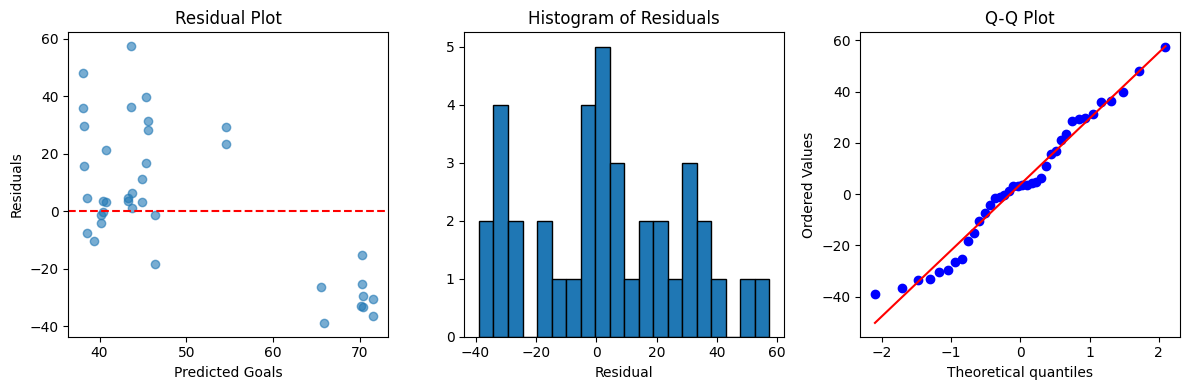

In [8]:
# 4.3 Residual Diagnostics (Example for goals_scored)


# Use the best model for goals_scored
X_test_goals, y_test_goals, _, _ = get_X_y(test, 'goals')
y_pred_goals = best_model.predict(X_test_goals)

residuals = y_test_goals - y_pred_goals

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(y_pred_goals, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Goals')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1,3,2)
plt.hist(residuals, bins=20, edgecolor='k')
plt.xlabel('Residual')
plt.title('Histogram of Residuals')

plt.subplot(1,3,3)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.savefig('residual_diagnostics.png')
plt.show()
